In [19]:
import torch
from torchvision import transforms
from embedder import Embedder
from predictor import DistancePredictor
from pathlib import Path
from typing import List
from PIL import Image
import json
import matplotlib.pyplot as plt

In [8]:
device = torch.device("mps")
supervectors_dir = "det_with_img_svs"

In [18]:
with open("/Users/iman/ML-Evaluation/data/products.json") as f:
    products = json.load(f)
product_data = {product["uuid"]: product for product in products}

In [13]:
model_root = Path("./model")
embedder = Embedder(trunk_weights=model_root / "trunk_weights.pth",
            embedder_weights=model_root / "embedder_weights.pth",
            device=device)

In [ ]:
def embed_crops(
    embedder, crops: List[torch.Tensor]
) -> torch.Tensor:
    """
    Embeds a list of crops using the embedder model.
    :param crops: List of crops as torch tensors.
    :param resize_size: Size to resize the crops to before embedding.
    :return: Embedded vectors as a torch tensor.
    """

    return embedder.embed(crops)

In [ ]:
resize = transforms.Resize(
    (224, 224),
    transforms.InterpolationMode.BILINEAR,
    antialias=True,
)
to_tensor = transforms.ToTensor()
img_supervectors = []
img_classes = []
images_dir = Path("/Users/iman/Desktop/snapple labels/crops_manual")
for folder in images_dir.iterdir():
    if not folder.is_dir():
        continue
    imgs = [Image.open(img) for img in folder.glob("*.png")]
    img_tensors = [resize(to_tensor(img)).to(device) for img in imgs]
    img_tensors = torch.stack(img_tensors)
    vectors = embed_crops(img_tensors)
    supervector = torch.mean(vectors, dim=0)
    supervector /= torch.linalg.norm(supervector)
    img_supervectors.append(supervector)
    img_classes.append(folder.name)
img_supervectors = torch.stack(img_supervectors)
torch.save(img_supervectors, model_root / "img_supervectors.pt")

In [15]:
faiss_index_path = model_root / "faiss.index"
filtered_classes_path = (
        model_root / supervectors_dir / "classes.json"
    )
class_names_path = model_root / supervectors_dir / "classes.json"
supervectors_path = (model_root / supervectors_dir / "supervectors_det.pt")
predictor = DistancePredictor(
    faiss_index_path=faiss_index_path,
    class_names_path=class_names_path,
    use_gpu=device == "cuda",
    k_nearest=50,
    supervectors_path=supervectors_path,
    filtered_classes_path=filtered_classes_path,
)

In [16]:
def embed_predict_crops(embedder,predictor,crops):
    with torch.no_grad():
        resize = transforms.Resize(
            (224, 224),
            transforms.InterpolationMode.BILINEAR,
            antialias=True,
        )
        crops = torch.stack([resize(crop) for crop in crops])
        vectors = embedder.embed(crops)
        distances, preds_labels = predictor.predict_pt(vectors)
    return distances, preds_labels

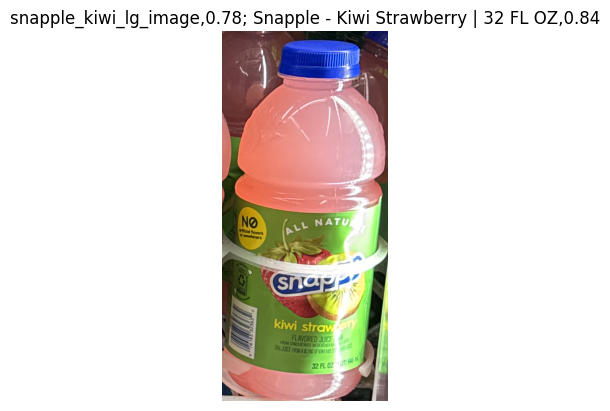

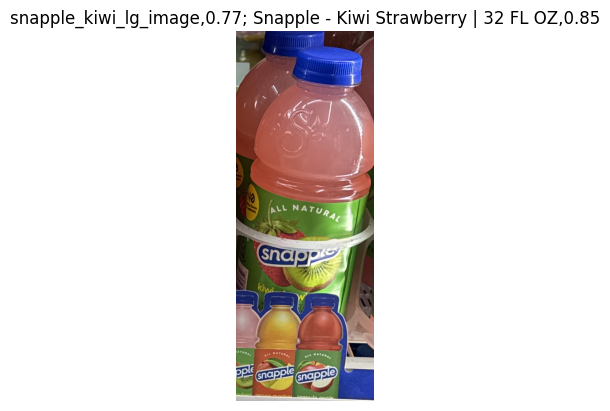

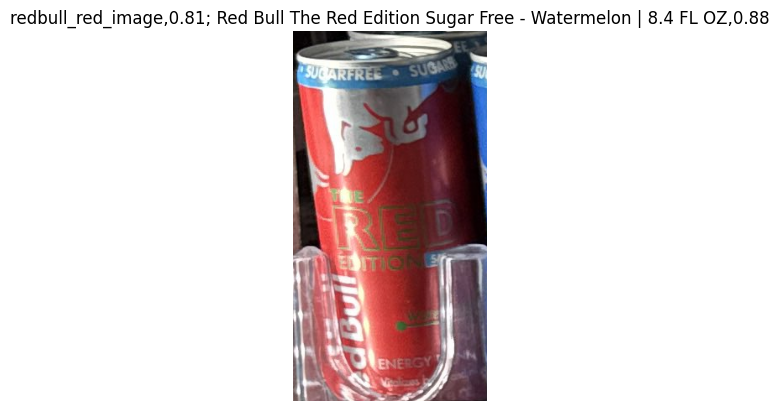

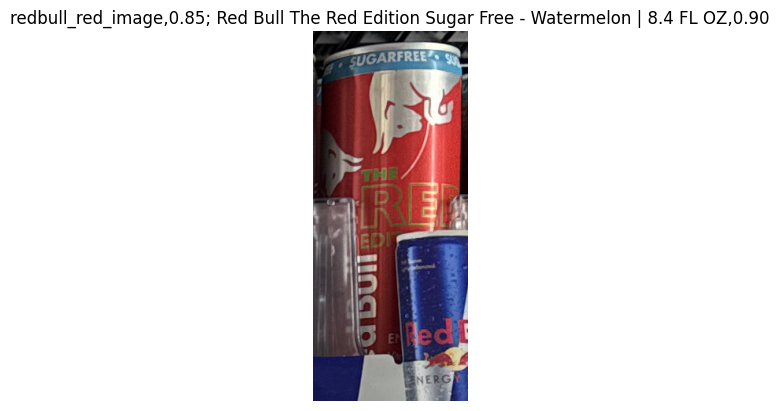

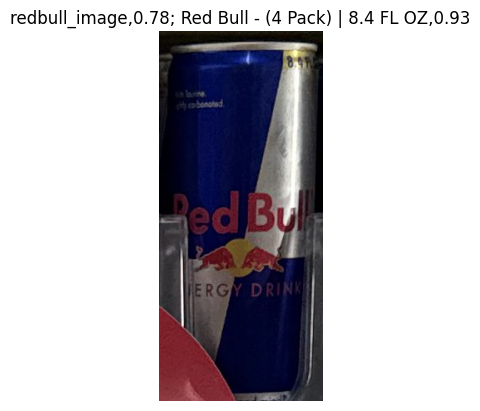

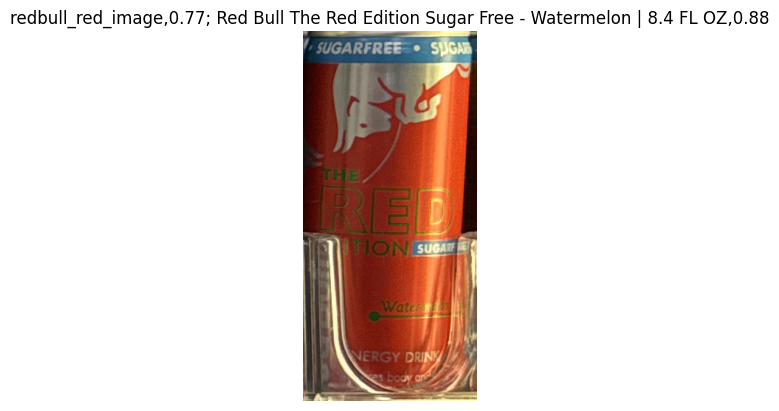

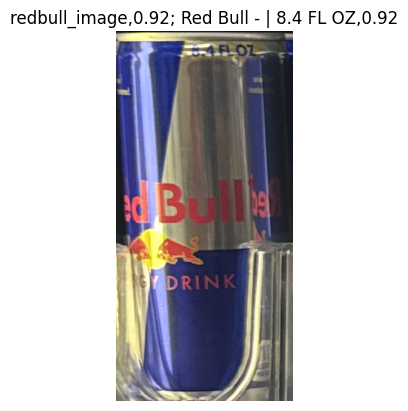

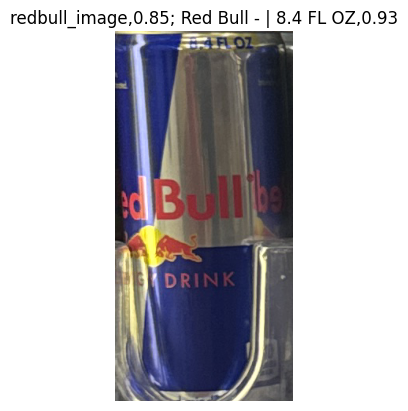

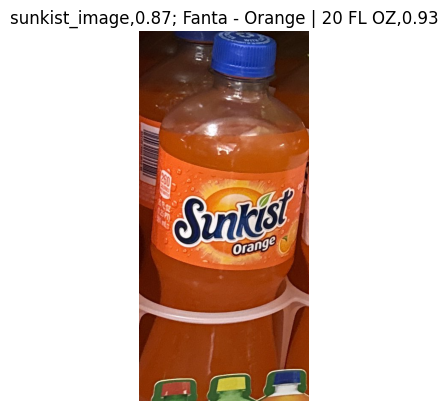

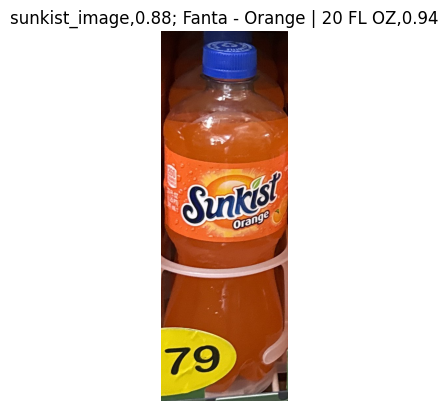

In [21]:
product_images_dir = Path("/Users/iman/Desktop/snapple labels/crops/checked")
to_tensor = transforms.ToTensor()
resize = transforms.Resize(
    (224, 224),
    transforms.InterpolationMode.BILINEAR,
    antialias=True,
)
results = {}
for folder in product_images_dir.iterdir():
    if not folder.is_dir():
        continue
    product_images = [Image.open(img) for img in folder.glob("*.png")]
    product_img_tensors = [resize(to_tensor(img)) for img in product_images]
    product_img_tensors = torch.stack(product_img_tensors)
    distances,predictions = embed_predict_crops(embedder,predictor,product_img_tensors)
    if folder.name not in results:
        results[folder.name] = []
    results[folder.name] = [preds[0] for preds in predictions]
    for i,(preds,dists) in enumerate(zip(predictions,distances)):
        if 'image' in preds[0]:
            second_pred_uuid = preds[1].split("_")[0]
            name = product_data[second_pred_uuid]["name"]
            plt.imshow(product_images[i])
            plt.axis('off')
            plt.title(f"{preds[0]},{dists[0]:.2f}; {name},{dists[1]:.2f}")
            plt.show()
